In [1]:
import pandas as pd
from pathlib import Path
import json
from pprint import pprint
import math
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

idx = pd.IndexSlice

RS_DIR = Path("data/random_search")
VERIFICATION_DIR = Path("data/verification")

In [2]:
def get_in_road_percentage(steps_df: pd.DataFrame) -> float:
    ret = steps_df["out_of_road"].value_counts(normalize=True).at[False]
    return ret

In [3]:
def get_n_sidewalk_crashes(steps_df: pd.DataFrame) -> int:
    """Count number of crash episodes to not count same crash multiple times"""
    try:
        # count number of times "crash" becomes True for some time
        n_crashes = steps_df["crash_sidewalk"].diff().value_counts().at[True]

        # need to divide by 2 beacouse diff counts twice
        n_crashes /= 2

        # just in case crash is last episode and we have 3.5 crash episodes make it 4
        n_crashes = math.ceil(n_crashes)
    except KeyError:
        n_crashes = 0

    return n_crashes

In [4]:
def process_steps(steps_infos: list) -> dict:
    """Accepts a list of steps and returns a dict of interesting data"""

    steps_df = pd.DataFrame(steps_infos)
    steps_data = {}
    last_step = steps_df.iloc[-1]

    steps_data = {
        "termination.arrive_dest": last_step["arrive_dest"],
        "termination.timeout": last_step["max_step"],
        "route_completion": last_step["route_completion"],
        "seed": last_step["env_seed"],
        "in_road_percentage": get_in_road_percentage(steps_df),
        "n_sidewalk_crashes": get_n_sidewalk_crashes(steps_df),
    }

    return steps_data

## Process random search traces


In [5]:
def get_random_search_traces():
    paths = list(RS_DIR.rglob("*.json"))

    scenarios = []
    for file_path in tqdm(paths):
        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))

        match file_path.parts:
            case (_, _, repetition, it, fid, _):
                # print(f"{rep =} {it= } {fid=}")
                scenario_data["repetition"] = int(repetition)
                scenario_data["iteration"] = int(it)

                _, dr, _, dt = fid.split("_")
                scenario_data["decision_repeat"] = int(dr)
                scenario_data["dt"] = float(dt)

            case _:
                raise ValueError("Can't parse path!")

        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)

In [6]:
df = get_random_search_traces()

100%|██████████| 3754/3754 [00:11<00:00, 332.54it/s]


In [7]:
df = df.set_index(
    ["decision_repeat", "dt", "repetition", "iteration"],
)
df = df[~df.index.duplicated(keep="first")]
df = df.sort_index()
df

start_ts  initialized_ts  \
decision_repeat dt   repetition iteration                                  
5               0.02 0          0           84847.778848    84848.287701   
                                1           84908.850104    84909.394391   
                                2           84968.489731    84968.965881   
                                3           85040.087931    85040.505547   
                                4           85109.373908    85109.839067   
...                                                  ...             ...   
20              0.04 9          39         159188.228142   159188.707152   
                                40         159195.149690   159195.621812   
                                41         159223.608681   159225.069041   
                                42         159233.518110   159233.984298   
                                43         159257.709568   159259.036176   

                                           scenario_done_ts  init_time  \
decision_repeat dt   repetition iteration                                
5               0.02 0          0              84908.298831   0.508852   
                                1              84967.954766   0.544287   
                                2              85039.513441   0.476150   
                                3              85108.831804   0.417616   
                                4              85163.665898   0.465158   
...                                                     ...        ...   
20              0.04 9          39            159193.551117   0.479010   
                                40            159221.989382   0.472122   
                                41            159231.915717   1.460360   
                                42            159256.108600   0.466188   
                                43            159296.257125   1.326608   

                                           scenario_time  total_time  \
decision_repeat dt   repetition iteration                              
5               0.02 0          0              60.011130   60.519983   
                                1              58.560375   59.104663   
                                2              70.547560   71.023710   
                                3              68.326257   68.743873   
                                4              53.826831   54.291989   
...                                                  ...         ...   
20              0.04 9          39              4.843965    5.322975   
                                40             26.367570   26.839692   
                                41              6.846675    8.307035   
                                42             22.124302   22.590489   
                                43             37.220949   38.547557   

                                           n_crashed_vehicles  \
decision_repeat dt   repetition iteration                       
5               0.02 0          0                           0   
                                1                           0   
                                2                           0   
                                3                           1   
                                4                           0   
...                                                       ...   
20              0.04 9          39                          0   
                                40                          2   
                                41                          1   
                                42                          2   
                                43                          3   

                                                                                    map_data  \
decision_repeat dt   repetition iteration                                                      
5               0.02 0          0          [{'id': 'I', 'pre_block_socket_index': None}, ...   
                         

In [8]:
# calculate driving score
# ! Problem changing the values here in the analysis can change % error


def calculate_driving_score(df):
    df["driving_score"] = (
        df["route_completion"]
        * df["in_road_percentage"]
        * (0.65) ** df["n_sidewalk_crashes"]
        * (0.60) ** df["n_crashed_vehicles"]
    )
    return df


df = calculate_driving_score(df)

In [9]:
def get_solutions_of_iteration(curr_it, df):

    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it]]

    # get index of minumum driving score -> solution
    solutions_idx = (
        slice.groupby(
            [
                "decision_repeat",
                "dt",
                "repetition",
            ]
        )["driving_score"]
        .idxmin()
        .rename("solution_idx")
    ).to_frame()

    solutions_idx["iteration"] = curr_it
    solutions_idx = solutions_idx.reset_index().set_index(
        ["decision_repeat", "dt", "repetition", "iteration"]
    )

    return solutions_idx

In [10]:
iterations = df.index.get_level_values("iteration").unique()
iterations

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55],
      dtype='int64', name='iteration')

In [11]:
sols_df = pd.concat([get_solutions_of_iteration(it, df) for it in iterations], axis=0)
sols_df = sols_df.sort_index()
sols_index = pd.MultiIndex.from_tuples(sols_df["solution_idx"])

In [12]:
# df = df[["driving_score", "seed", "total_time"]]
sols_df = df[["driving_score", "seed"]].loc[sols_index]
sols_df

driving_score        seed
decision_repeat dt   repetition iteration                           
5               0.02 0          0               0.991255  6750770235
                                0               0.991255  6750770235
                                0               0.991255  6750770235
                                3               0.596023  6019026122
                                3               0.596023  6019026122
...                                                  ...         ...
20              0.04 9          43              0.065915  4201819610
                                43              0.065915  4201819610
                                43              0.065915  4201819610
                                43              0.065915  4201819610
                                43              0.065915  4201819610

[6720 rows x 2 columns]

In [13]:
sols_df = sols_df.reset_index()
sols_df = sols_df.rename(
    columns={"iteration": "solutions_iteration", "driving_score": "solution_dscore"}
)
sols_df["iteration"] = sols_df.groupby(
    ["decision_repeat", "dt", "repetition"]
).cumcount()

sols_df = sols_df.set_index(["decision_repeat", "dt", "repetition", "iteration"])

In [14]:
sols_df
# insert verified driving score here

solutions_iteration  \
decision_repeat dt   repetition iteration                        
5               0.02 0          0                            0   
                                1                            0   
                                2                            0   
                                3                            3   
                                4                            3   
...                                                        ...   
20              0.04 9          51                          43   
                                52                          43   
                                53                          43   
                                54                          43   
                                55                          43   

                                           solution_dscore        seed  
decision_repeat dt   repetition iteration                               
5               0.02 0          0                 0.991255  6750770235  
                                1                 0.991255  6750770235  
                                2                 0.991255  6750770235  
                                3                 0.596023  6019026122  
                                4                 0.596023  6019026122  
...                                                    ...         ...  
20              0.04 9          51                0.065915  4201819610  
                                52                0.065915  4201819610  
                                53                0.065915  4201819610  
                                54                0.065915  4201819610  
                                55                0.065915  4201819610  

[6720 rows x 3 columns]

In [15]:
df

start_ts  initialized_ts  \
decision_repeat dt   repetition iteration                                  
5               0.02 0          0           84847.778848    84848.287701   
                                1           84908.850104    84909.394391   
                                2           84968.489731    84968.965881   
                                3           85040.087931    85040.505547   
                                4           85109.373908    85109.839067   
...                                                  ...             ...   
20              0.04 9          39         159188.228142   159188.707152   
                                40         159195.149690   159195.621812   
                                41         159223.608681   159225.069041   
                                42         159233.518110   159233.984298   
                                43         159257.709568   159259.036176   

                                           scenario_done_ts  init_time  \
decision_repeat dt   repetition iteration                                
5               0.02 0          0              84908.298831   0.508852   
                                1              84967.954766   0.544287   
                                2              85039.513441   0.476150   
                                3              85108.831804   0.417616   
                                4              85163.665898   0.465158   
...                                                     ...        ...   
20              0.04 9          39            159193.551117   0.479010   
                                40            159221.989382   0.472122   
                                41            159231.915717   1.460360   
                                42            159256.108600   0.466188   
                                43            159296.257125   1.326608   

                                           scenario_time  total_time  \
decision_repeat dt   repetition iteration                              
5               0.02 0          0              60.011130   60.519983   
                                1              58.560375   59.104663   
                                2              70.547560   71.023710   
                                3              68.326257   68.743873   
                                4              53.826831   54.291989   
...                                                  ...         ...   
20              0.04 9          39              4.843965    5.322975   
                                40             26.367570   26.839692   
                                41              6.846675    8.307035   
                                42             22.124302   22.590489   
                                43             37.220949   38.547557   

                                           n_crashed_vehicles  \
decision_repeat dt   repetition iteration                       
5               0.02 0          0                           0   
                                1                           0   
                                2                           0   
                                3                           1   
                                4                           0   
...                                                       ...   
20              0.04 9          39                          0   
                                40                          2   
                                41                          1   
                                42                          2   
                                43                          3   

                                                                                    map_data  \
decision_repeat dt   repetition iteration                                                      
5               0.02 0          0          [{'id': 'I', 'pre_block_socket_index': None}, ...   
                         

### Add cumulation time


In [16]:
cumulative_time = df.groupby(["decision_repeat", "dt", "repetition"])[
    "total_time"
].cumsum()

In [17]:
sols_df = sols_df.join(cumulative_time)
sols_df

solutions_iteration  \
decision_repeat dt   repetition iteration                        
5               0.02 0          0                            0   
                                1                            0   
                                2                            0   
                                3                            3   
                                4                            3   
...                                                        ...   
20              0.04 9          51                          43   
                                52                          43   
                                53                          43   
                                54                          43   
                                55                          43   

                                           solution_dscore        seed  \
decision_repeat dt   repetition iteration                                
5               0.02 0          0                 0.991255  6750770235   
                                1                 0.991255  6750770235   
                                2                 0.991255  6750770235   
                                3                 0.596023  6019026122   
                                4                 0.596023  6019026122   
...                                                    ...         ...   
20              0.04 9          51                0.065915  4201819610   
                                52                0.065915  4201819610   
                                53                0.065915  4201819610   
                                54                0.065915  4201819610   
                                55                0.065915  4201819610   

                                           total_time  
decision_repeat dt   repetition iteration              
5               0.02 0          0           60.519983  
                                1          119.624646  
                                2          190.648355  
                                3          259.392229  
                                4          313.684218  
...                                               ...  
20              0.04 9          51                NaN  
                                52                NaN  
                                53                NaN  
                                54                NaN  
                                55                NaN  

[6720 rows x 4 columns]

## Load verification data


In [18]:
def get_verification() -> pd.DataFrame:
    paths = list(VERIFICATION_DIR.rglob("*.json"))

    scenarios = []
    for file_path in tqdm(paths):
        with open(file_path, "r") as f:
            scenario_data = json.load(f)

        steps_infos = scenario_data.pop("steps_infos")
        scenario_data.update(process_steps(steps_infos))
        scenarios.append(scenario_data)
    return pd.DataFrame(scenarios)


ver_df = get_verification().set_index("seed")
ver_df = calculate_driving_score(ver_df)
ver_df = ver_df["driving_score"].rename("verified_driving_score")

100%|██████████| 2900/2900 [00:23<00:00, 122.96it/s]


In [19]:
# sols_df = sols_df[["seed", "solutions_iteration", "solution_dscore"]]
sols_df = sols_df.join(ver_df, on="seed", rsuffix="_verified")

## Plot


In [20]:
data = sols_df.groupby(["decision_repeat", "dt", "iteration"]).mean()

<Axes: xlabel='iteration', ylabel='solution_dscore'>

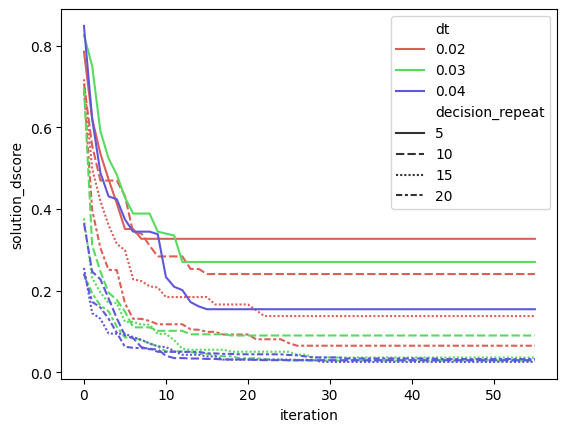

In [21]:
palette = sns.color_palette("hls", 3)
sns.lineplot(
    data,
    x="iteration",
    y="solution_dscore",
    style="decision_repeat",
    hue="dt",
    palette=palette,
)

In [22]:
data = data.groupby(["decision_repeat", "dt", "iteration"]).mean()

/tmp/ipykernel_186141/1719338052.py:12: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  ax = sns.lineplot(


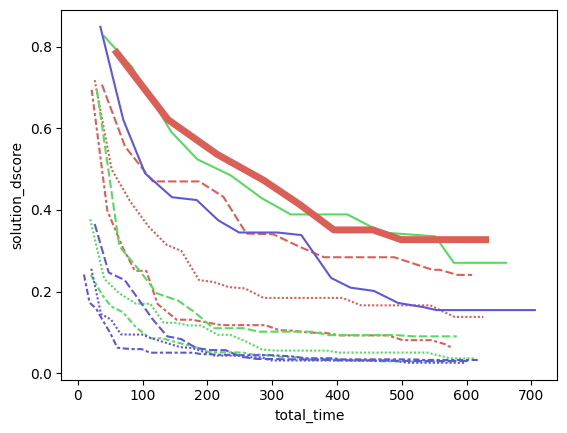

In [31]:
sns.lineplot(
    data,
    x="total_time",
    y="solution_dscore",
    style="decision_repeat",
    hue="dt",
    palette=palette,
    errorbar=None,
)


ax = sns.lineplot(
    data.xs((5, 0.02), drop_level=False),
    x="total_time",
    y="solution_dscore",
    style="decision_repeat",
    hue="dt",
    palette=palette,
    errorbar=None,
    lw=5,
)
ax.get_legend().remove()

/tmp/ipykernel_186141/3788056927.py:12: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  ax = sns.lineplot(


(0.0, 0.9839057050997394)

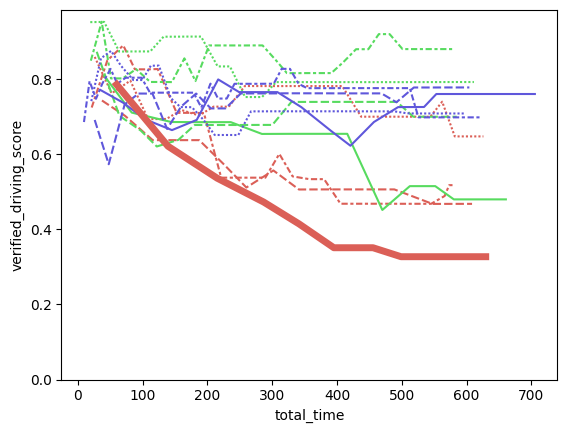

In [32]:
ax = sns.lineplot(
    data,
    x="total_time",
    y="verified_driving_score",
    style="decision_repeat",
    hue="dt",
    palette=palette,
    errorbar=None,
)


ax = sns.lineplot(
    data.xs((5, 0.02), drop_level=False),
    x="total_time",
    y="verified_driving_score",
    style="decision_repeat",
    hue="dt",
    palette=palette,
    errorbar=None,
    lw=5,
)
ax.get_legend().remove()


# ax.set_ylim(0)